# DSCI 100 Group 84 Project
### Alyssa Aguason, Russell Ly, Sam Tong, Eric Yee

## Introduction

Auditing is the process of conducting financial examinations to investigate possibly fraudulent firms. An external investigation is done using quantitative financial data, and an internal investigation follows if the firm is at risk. The external process is a timely task that could be improved by using a classification model. Thus, our question is **can we build a classification model that will predict a firm’s risk of fraud and find whether or not this model would be accurate enough to use in an external auditing process?**

The data was collected by the Comptroller and Auditor General (CAG) of India for a total of 777 firms in the year 2015. The dataset contains observations of financial data that auditors use during the external investigation. Note that some predictive columns are already scaled, exceptions being the columns “PARA_A”, “PARA_B”, “TOTAL”, and “Money_Value”.


## Preliminary Data Analysis

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
set.seed(1000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
destfile <- "audit.zip"
download.file(url, destfile)

unzip("audit.zip", list = TRUE)

Name,Length,Date
<chr>,<dbl>,<dttm>
audit_data/audit_risk.csv,81197,2018-07-14 13:04:00
audit_data/trial.csv,39965,2018-07-14 12:47:00


`trial.csv` has just the data with no evaluation scores from the original data collector's own models, so that is what we will use in this project.

In [3]:
audit_data <- read_csv(unzip("audit.zip", "audit_data/trial.csv")) |>
    mutate(Risk = as_factor(Risk))
head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


In [4]:
audit_prop <- audit_data |>
    group_by(Risk) |>
    summarize(count = n())
audit_prop

audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_train <- training(audit_split)
audit_test <- testing(audit_split) |>
    filter(Money_Value != "NA") 
    # One of the observations with a value of NA was causing issues later on

Risk,count
<fct>,<int>
0,290
1,486


290 of the businesses in the dataset were not detected of fraud, while 486 of the businesses were.

In [5]:
mean_train <- audit_train |>
    group_by(Risk) |>
    summarize(mean_para_a = mean(PARA_A),
              mean_para_b = mean(PARA_B),
              mean_money_value = mean(Money_Value, na.rm = TRUE),
              mean_sector_score = mean(Sector_score),
              mean_loss_score = mean(LOSS_SCORE),
              mean_history_score = mean(History_score),
              mean_district_score = mean(District))
mean_train

Risk,mean_para_a,mean_para_b,mean_money_value,mean_sector_score,mean_loss_score,mean_history_score,mean_district_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2876959,0.2527912,0.3009862,32.66742,2.000000,2.00000,2.000000
1,3.8406885,18.8677473,24.2730769,13.67192,2.093407,2.28022,2.736264


This summary table outlines the average (mean) values of each variable we are using from the training data, separated by Risk (0 for businesses not detected of fraud, 1 for businesses detected of fraud).

In [6]:
options(repr.plot.width = 18, repr.plot.height = 8)

select_audit_train <- audit_train |>
    select(c(Risk, PARA_A, PARA_B, Money_Value, Sector_score, LOSS_SCORE, History_score, District)) |>
    filter(PARA_A < 50, PARA_B < 1000, Money_Value < 350) # high-value outliers removed for visual clarity and less empty space 

# Histograms for numeric variables
para_A <- ggplot(select_audit_train, aes(x = PARA_A, fill = Risk)) +
    geom_histogram(binwidth = 1.5) +
    xlab("Discrepency between Planned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

para_B <- ggplot(select_audit_train, aes(x = PARA_B, fill = Risk)) +
    geom_histogram(binwidth = 1.5) +
    xlab("Discrepency between Unplanned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

money_value <- ggplot(select_audit_train, aes(x = Money_Value, fill = Risk)) +
    geom_histogram(binwidth = 5) +
    xlab("Amount of Money Involved in Misstatements in Past Audits in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

sector <- ggplot(select_audit_train, aes(x = Sector_score, fill = Risk)) +
    geom_histogram(binwidth = 3) +
    xlab("Historical Risk Score of Associated Sector") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

# Barplots for assigned score variables
loss <- ggplot(select_audit_train, aes(x = LOSS_SCORE, fill = Risk)) +
    geom_bar() +
    xlab("Assigned Score of Loss Suffered by Firm in Previous Year") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

history <- ggplot(select_audit_train, aes(x = History_score, fill = Risk)) +
    geom_bar() +
    xlab("Assigned Score of Average Historical Loss Suffered by Firm in Past 10 Years") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

district <- ggplot(select_audit_train, aes(x = District, fill = Risk)) +
    geom_bar() +
    xlab("Assigned Score of Average Historical Risk Score of District in Past 10 Years") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

The following visualizations display the distribution of values of the seven variables we plan to use to predict whether a business is detected of fraud. There are few columns in most of the graphs with a Risk score of 0 because there is often little/no discrepency found in the audit reports for businesses not detected of fraud.

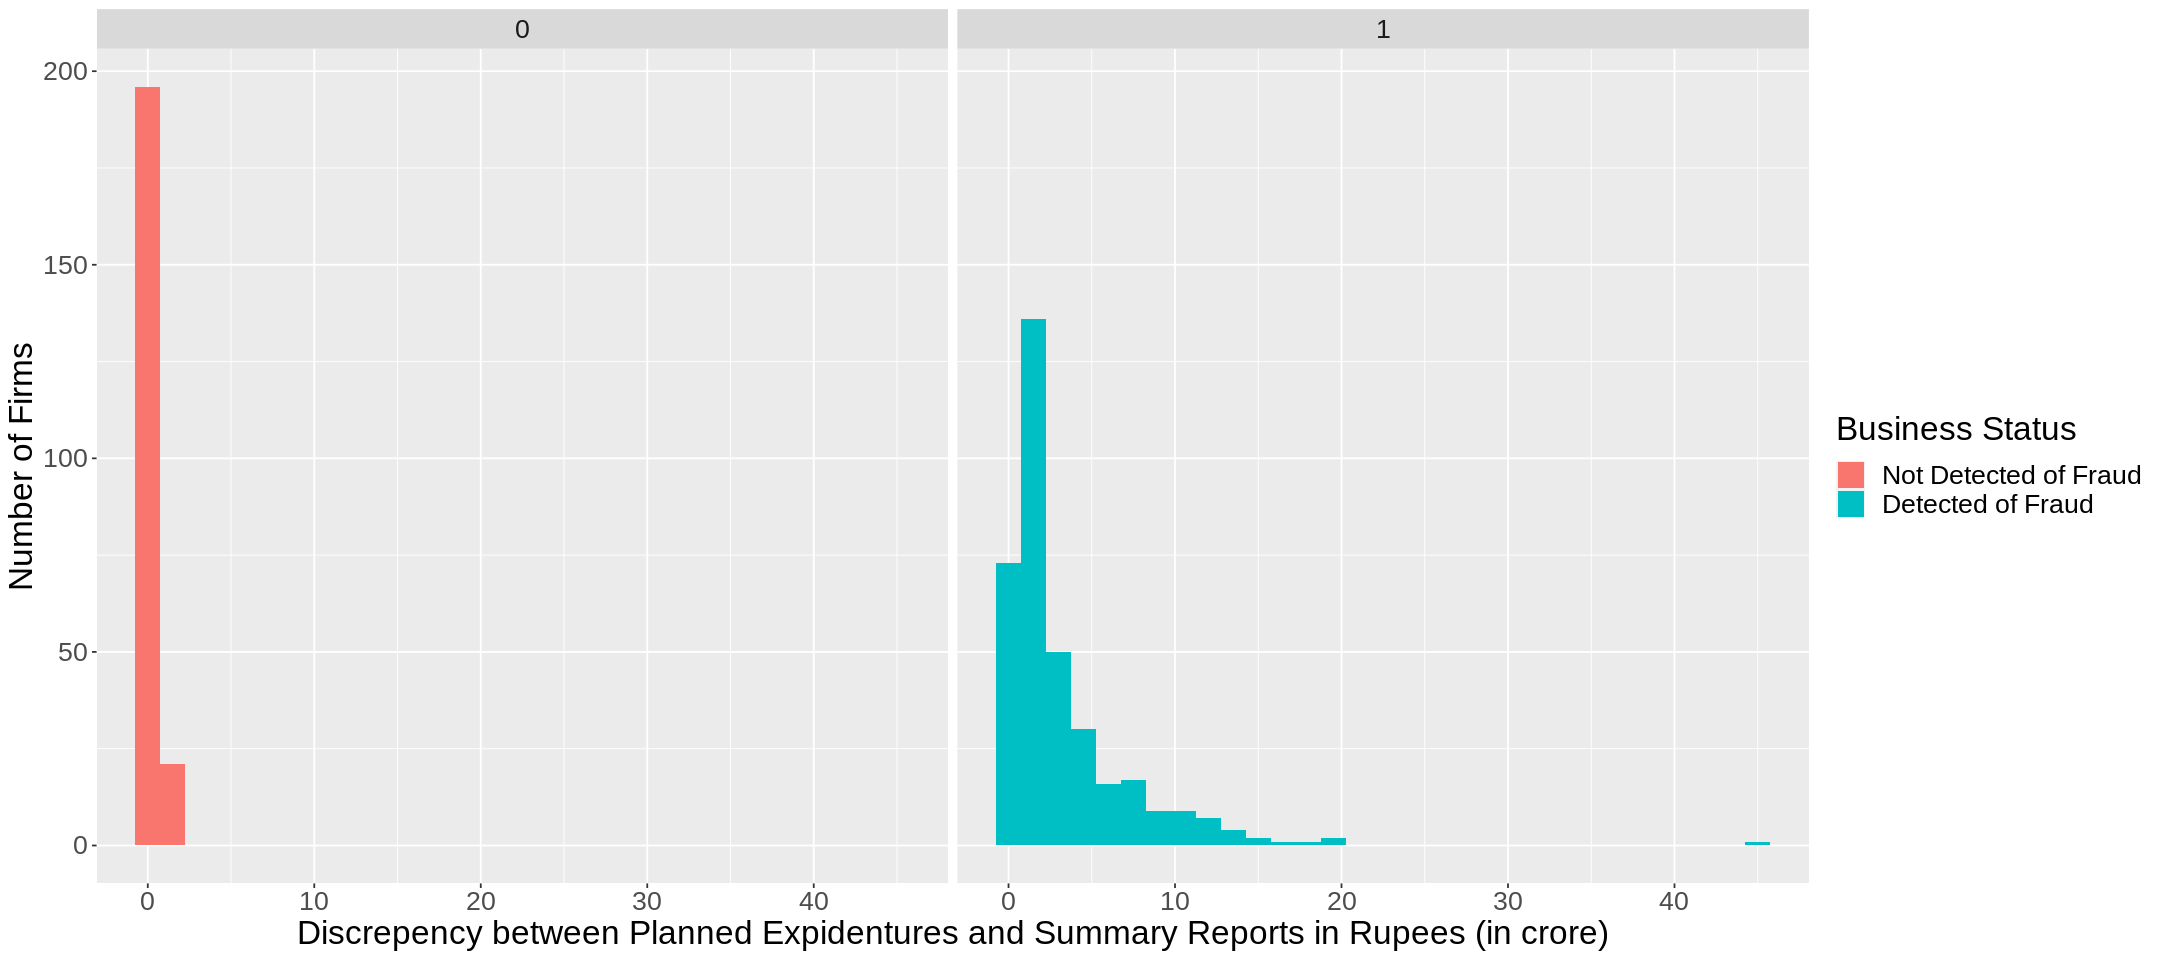

In [7]:
para_A

#### Figure 1: Para A

All of the businesses not detected of fraud had little to no discrepancy between planned expenditures and summary reports, while most of the businesses detected of fraud had at least a small discrepancy.

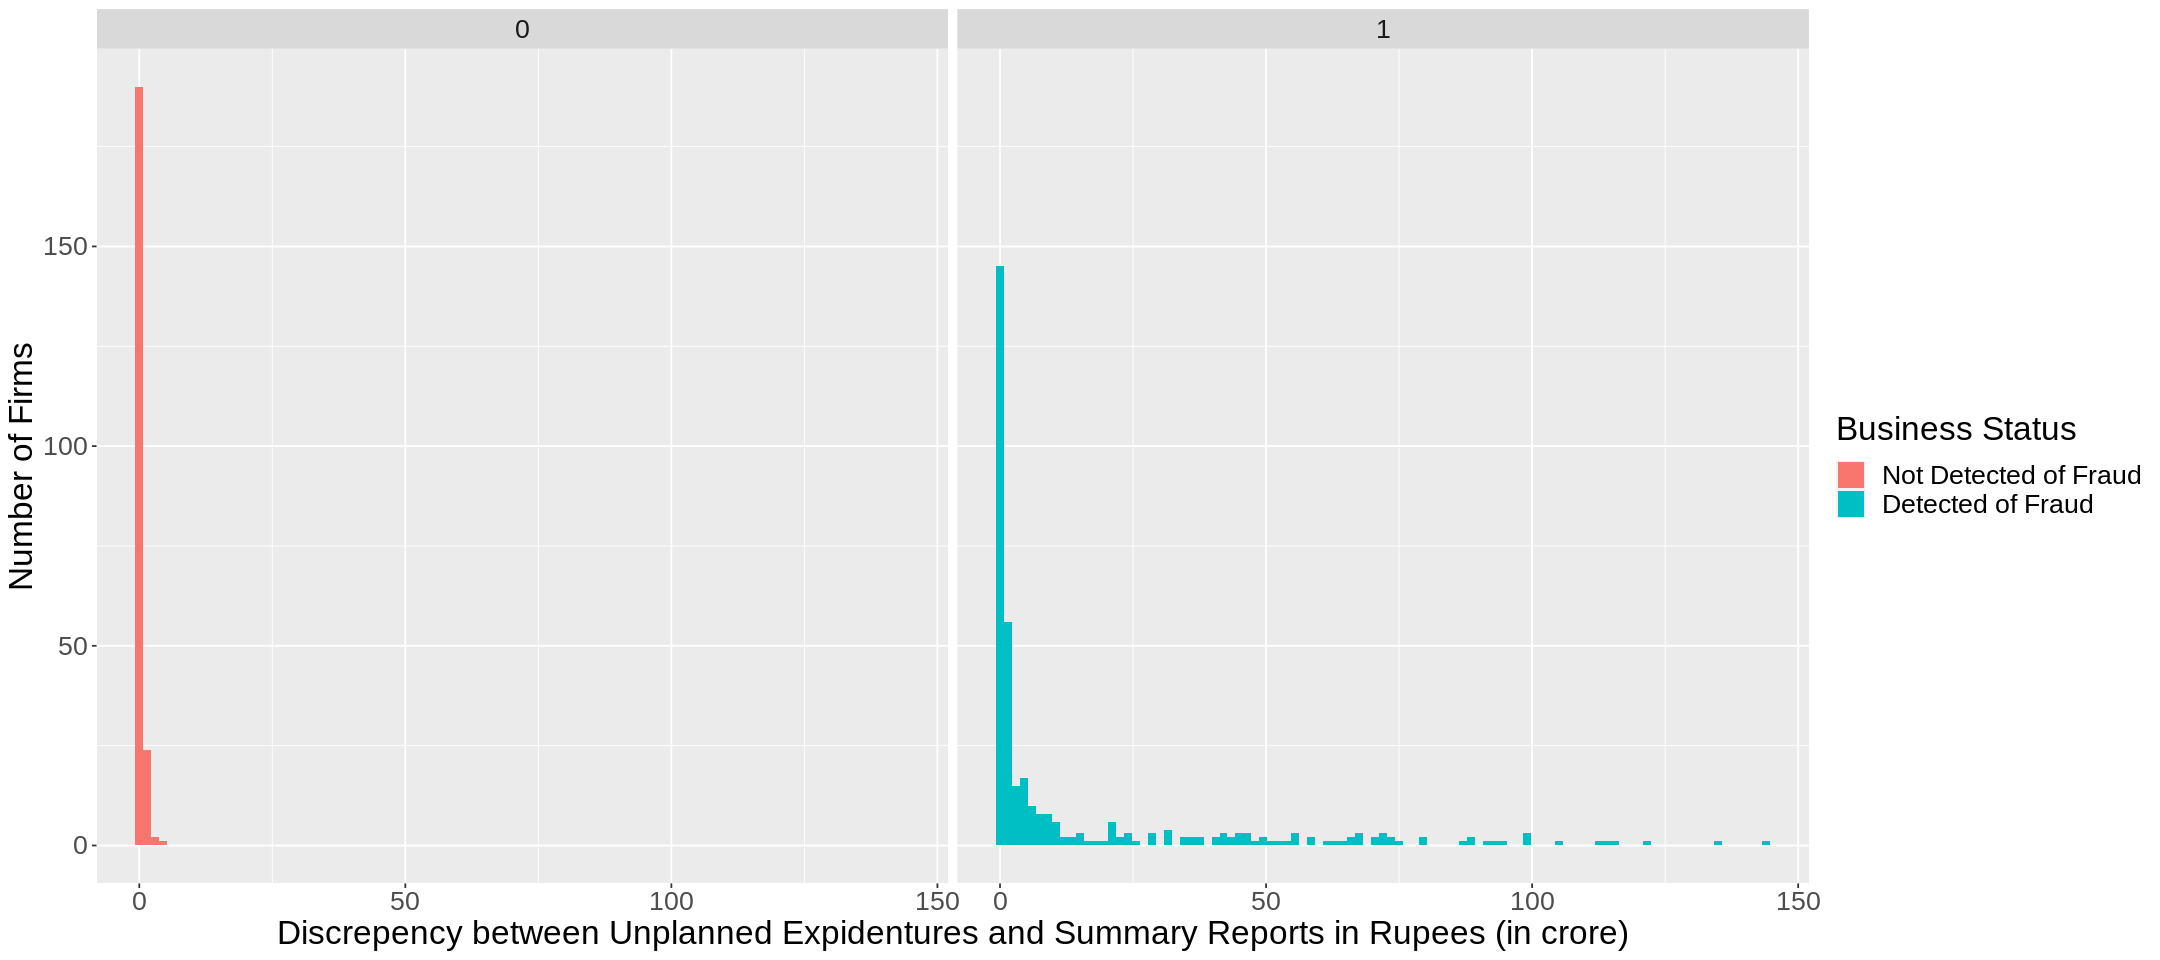

In [8]:
para_B

#### Figure 2: Para B
All of the businesses not detected of fraud had little to no discrepancy between unplanned expenditures and summary reports, while a good portion of the businesses detected of fraud had some significant level of discrepancy.

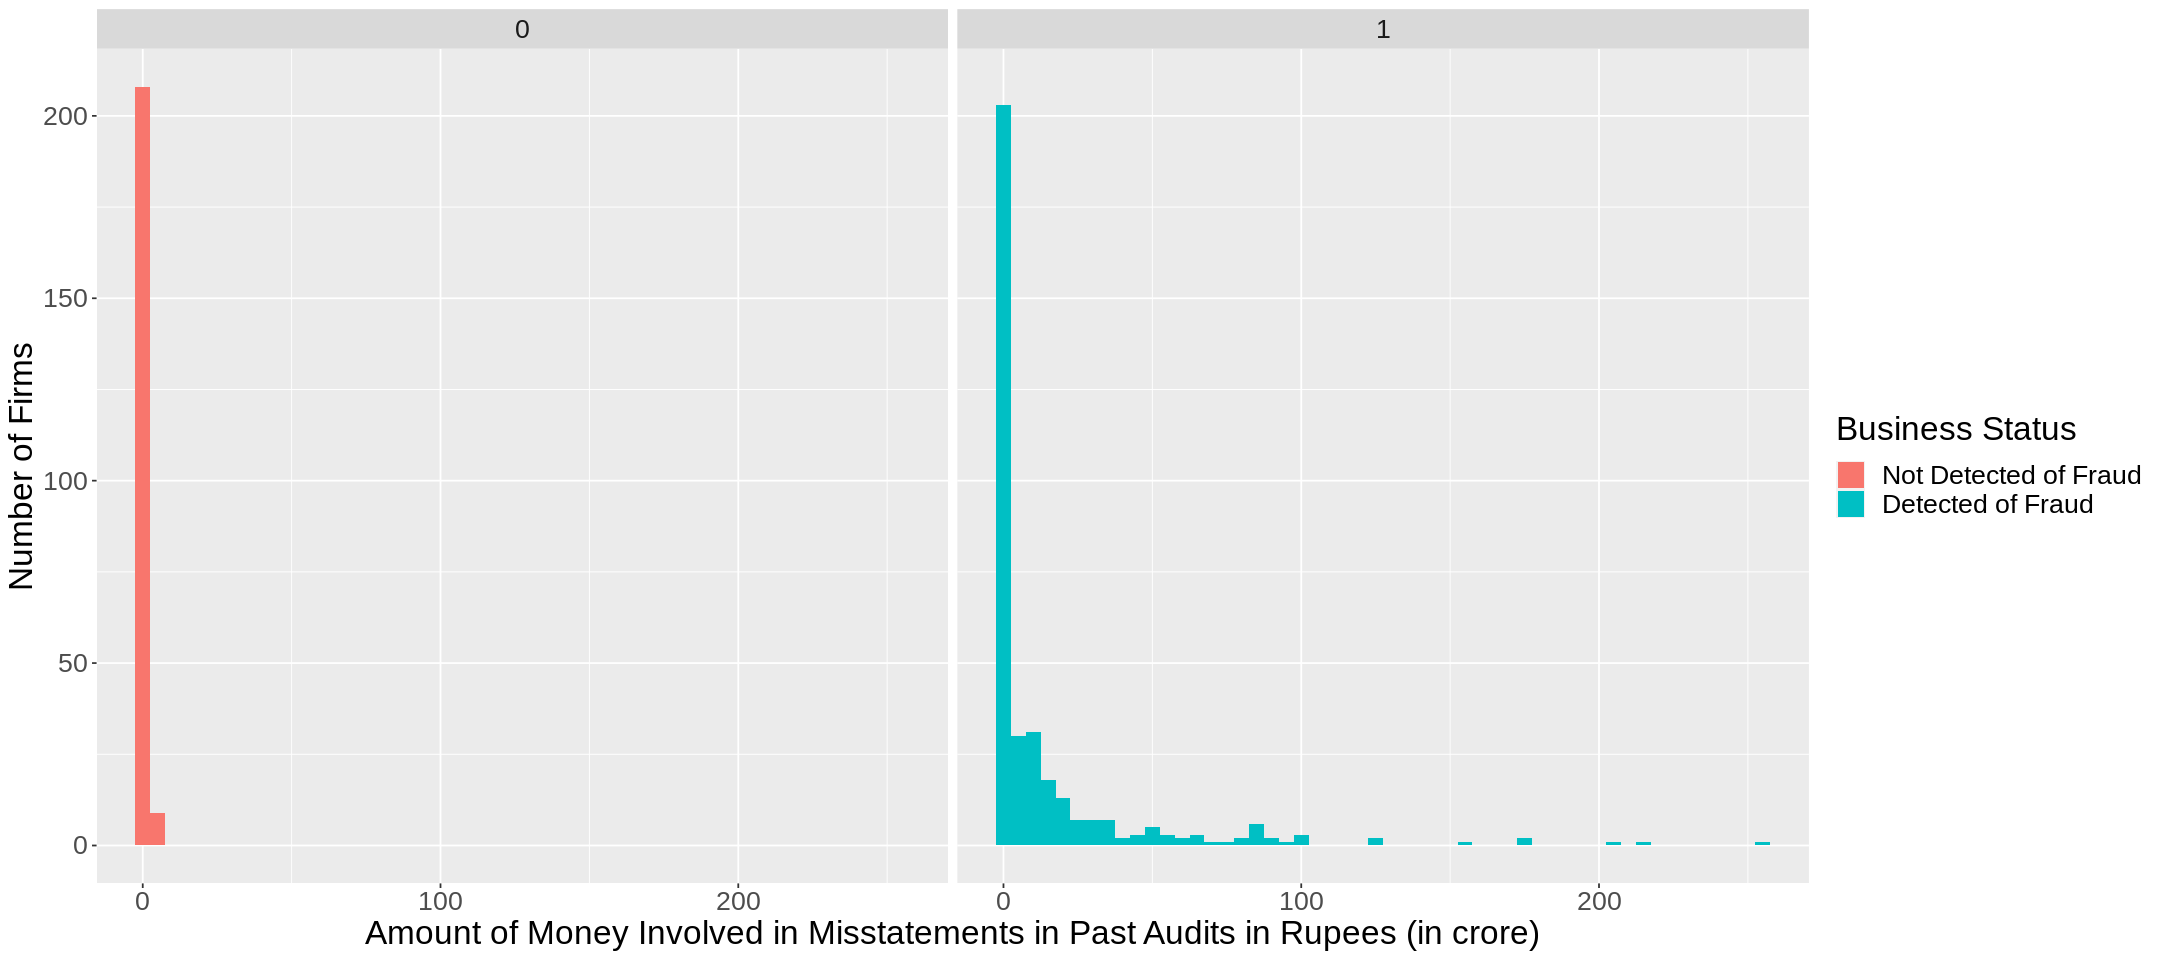

In [9]:
money_value

#### Figure 3: Money Value
All of the businesses not detected of fraud had very little to no money involved in misstatements in past audits, while some businesses detected of fraud had significant amounts of money involved in prior misstatements.

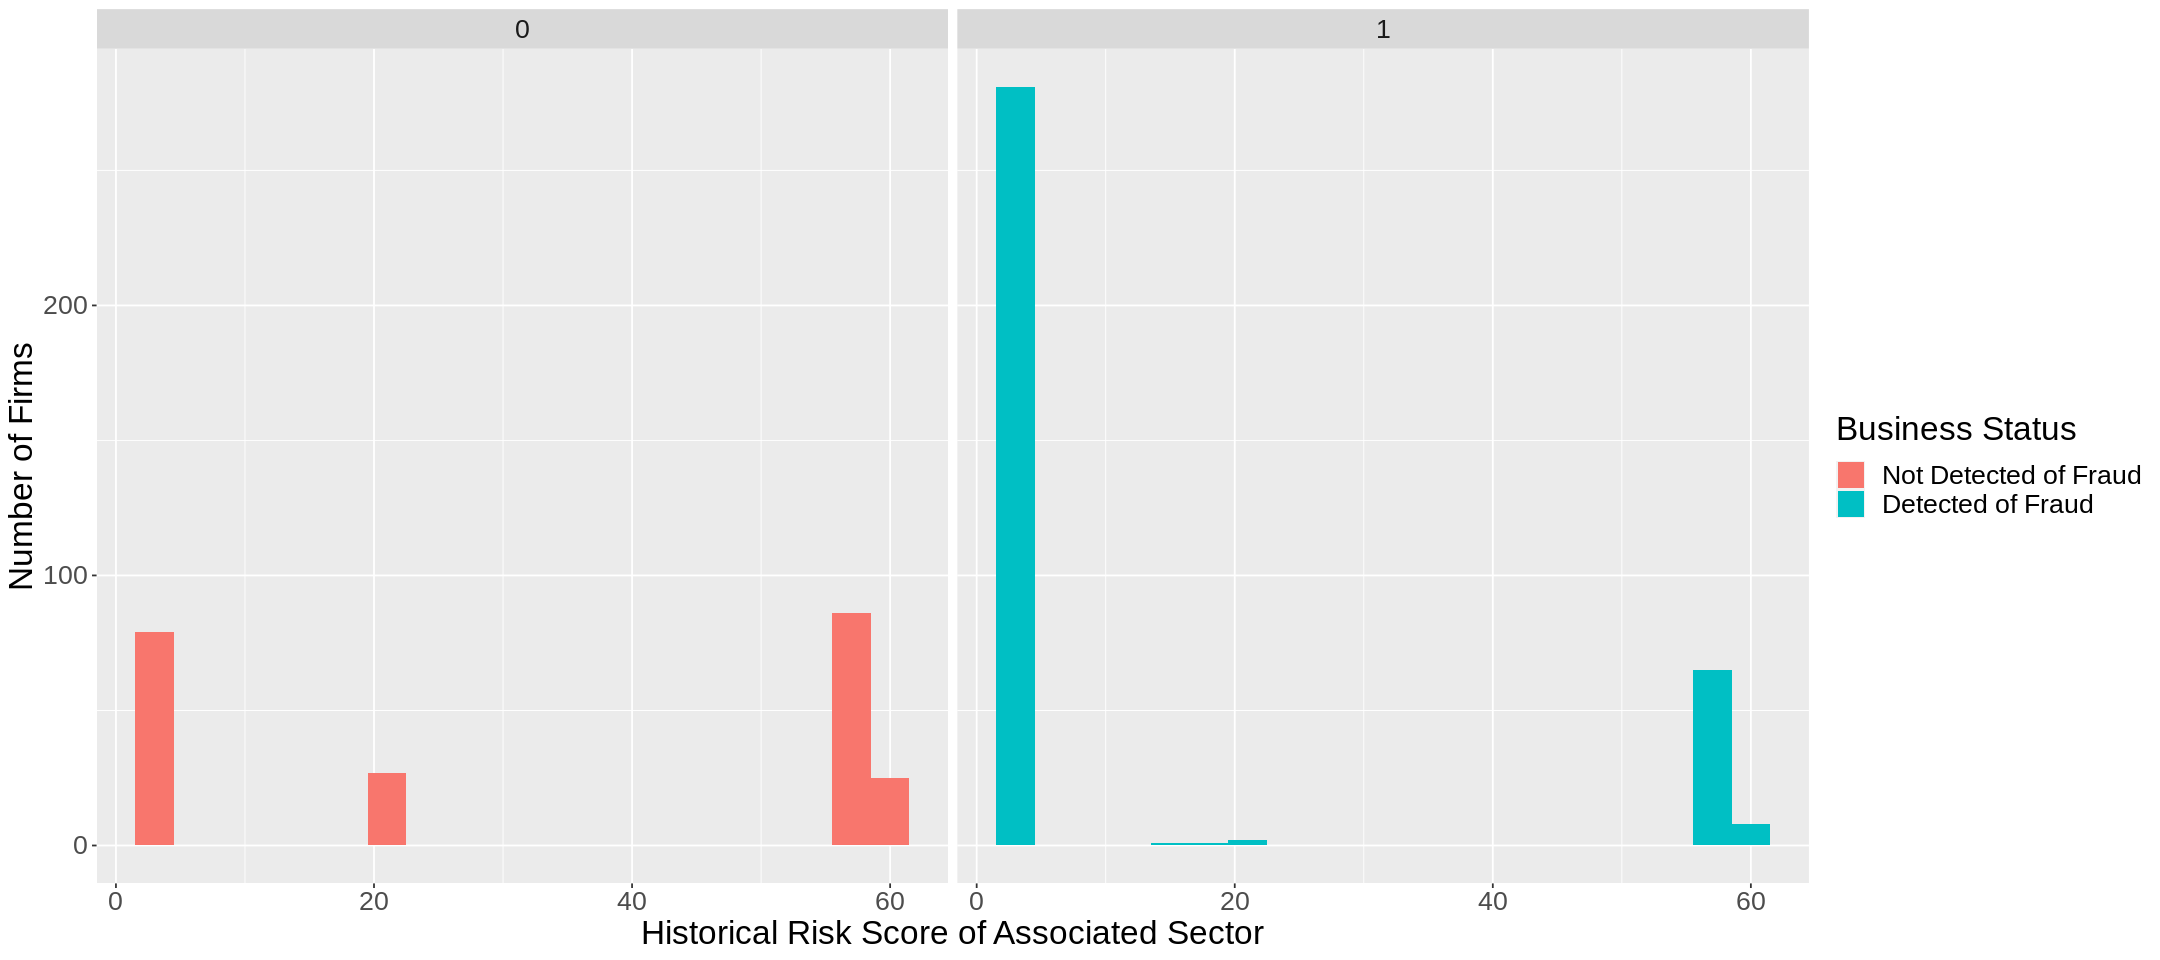

In [10]:
sector

#### Figure 4: Sector Score
These historical risk scores of the businesses’ associated sector (business type) were assigned by data collectors, with higher scores associated with higher risk. Businesses not detected of fraud had scores typically around 0 or 60, while businesses detected of fraud mostly had scores around 0, suggesting that fraudulent businesses likely tried to take advantage of their status as members of a “lower risk” sector.

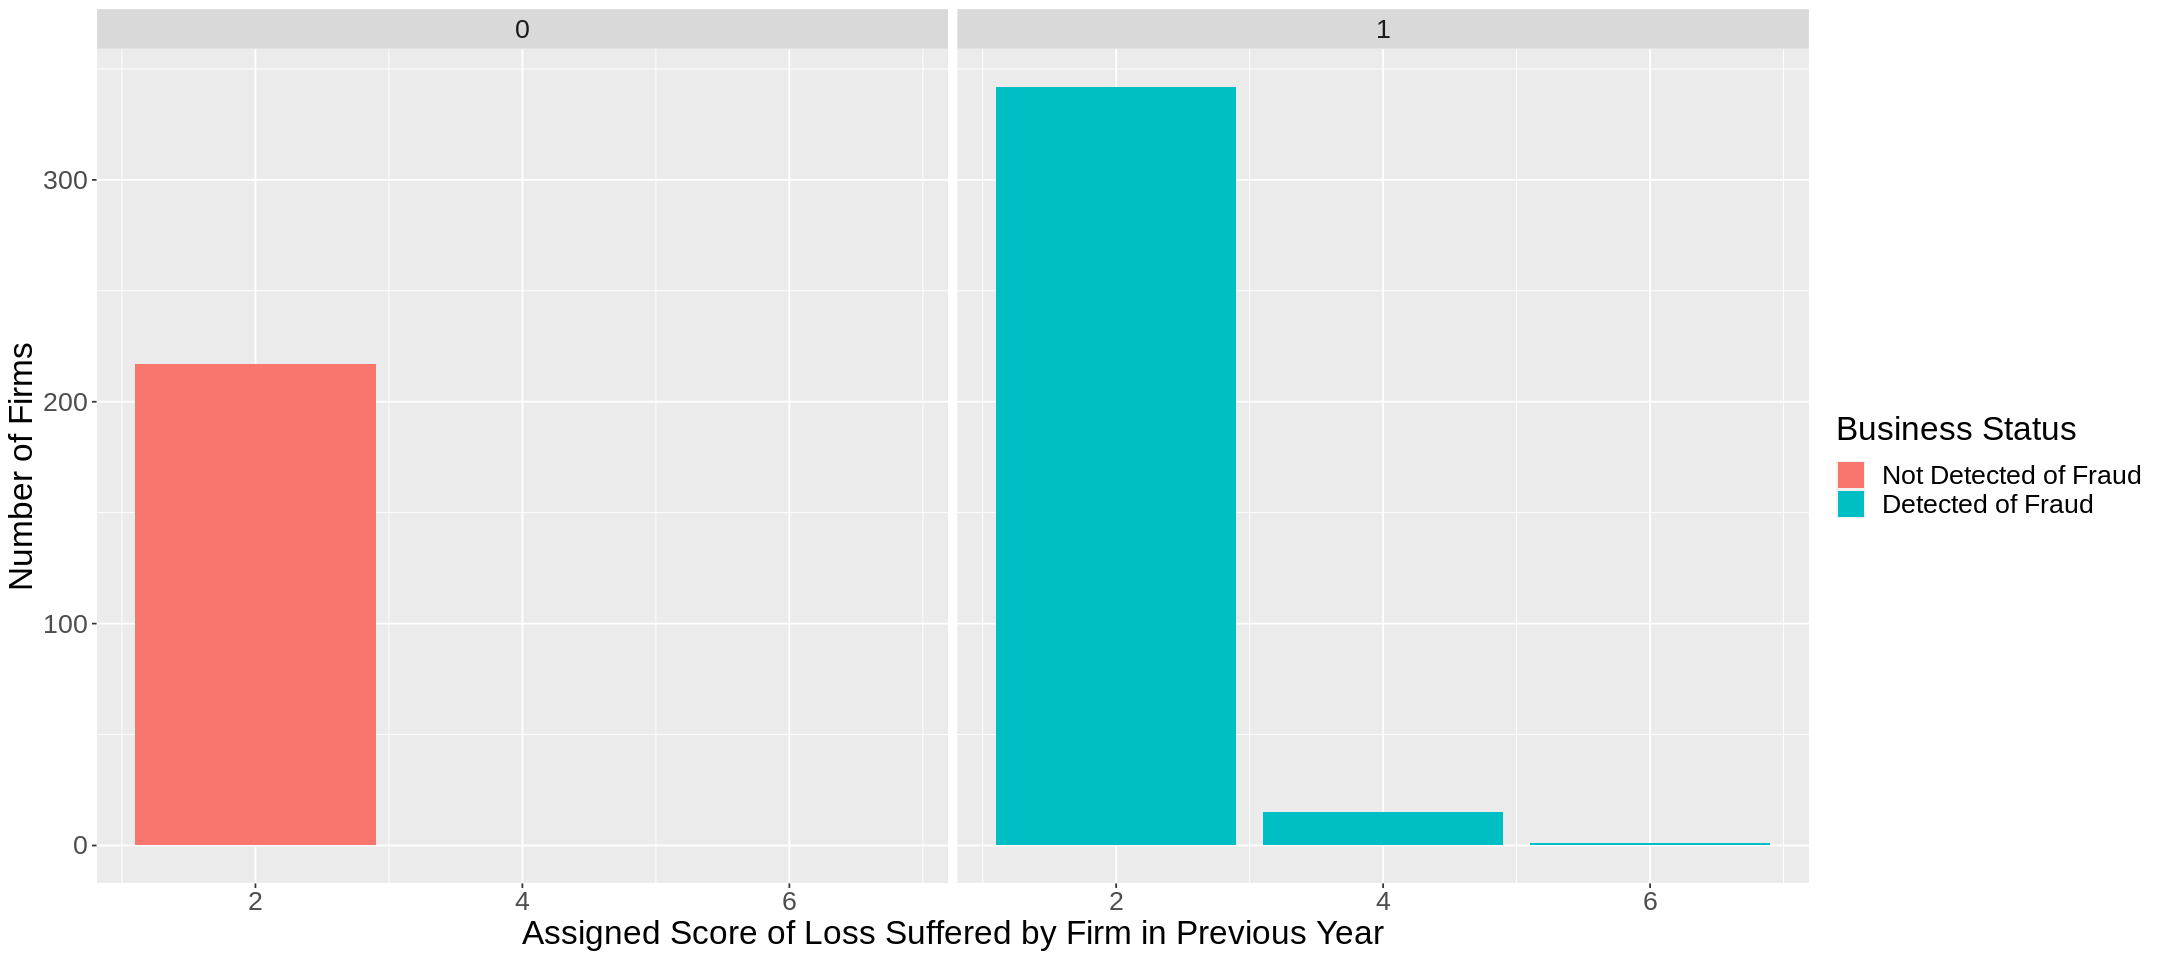

In [11]:
loss

#### Figure 5: Loss Score
These historical risk scores of the businesses’ associated historical financial loss from the past year were assigned by data collectors, with higher scores associated with higher risk. The businesses not detected of fraud all had historical loss scores of 2, while the businesses detected of fraud had scores of mostly 2, with a few having scores of 4 and 6. 

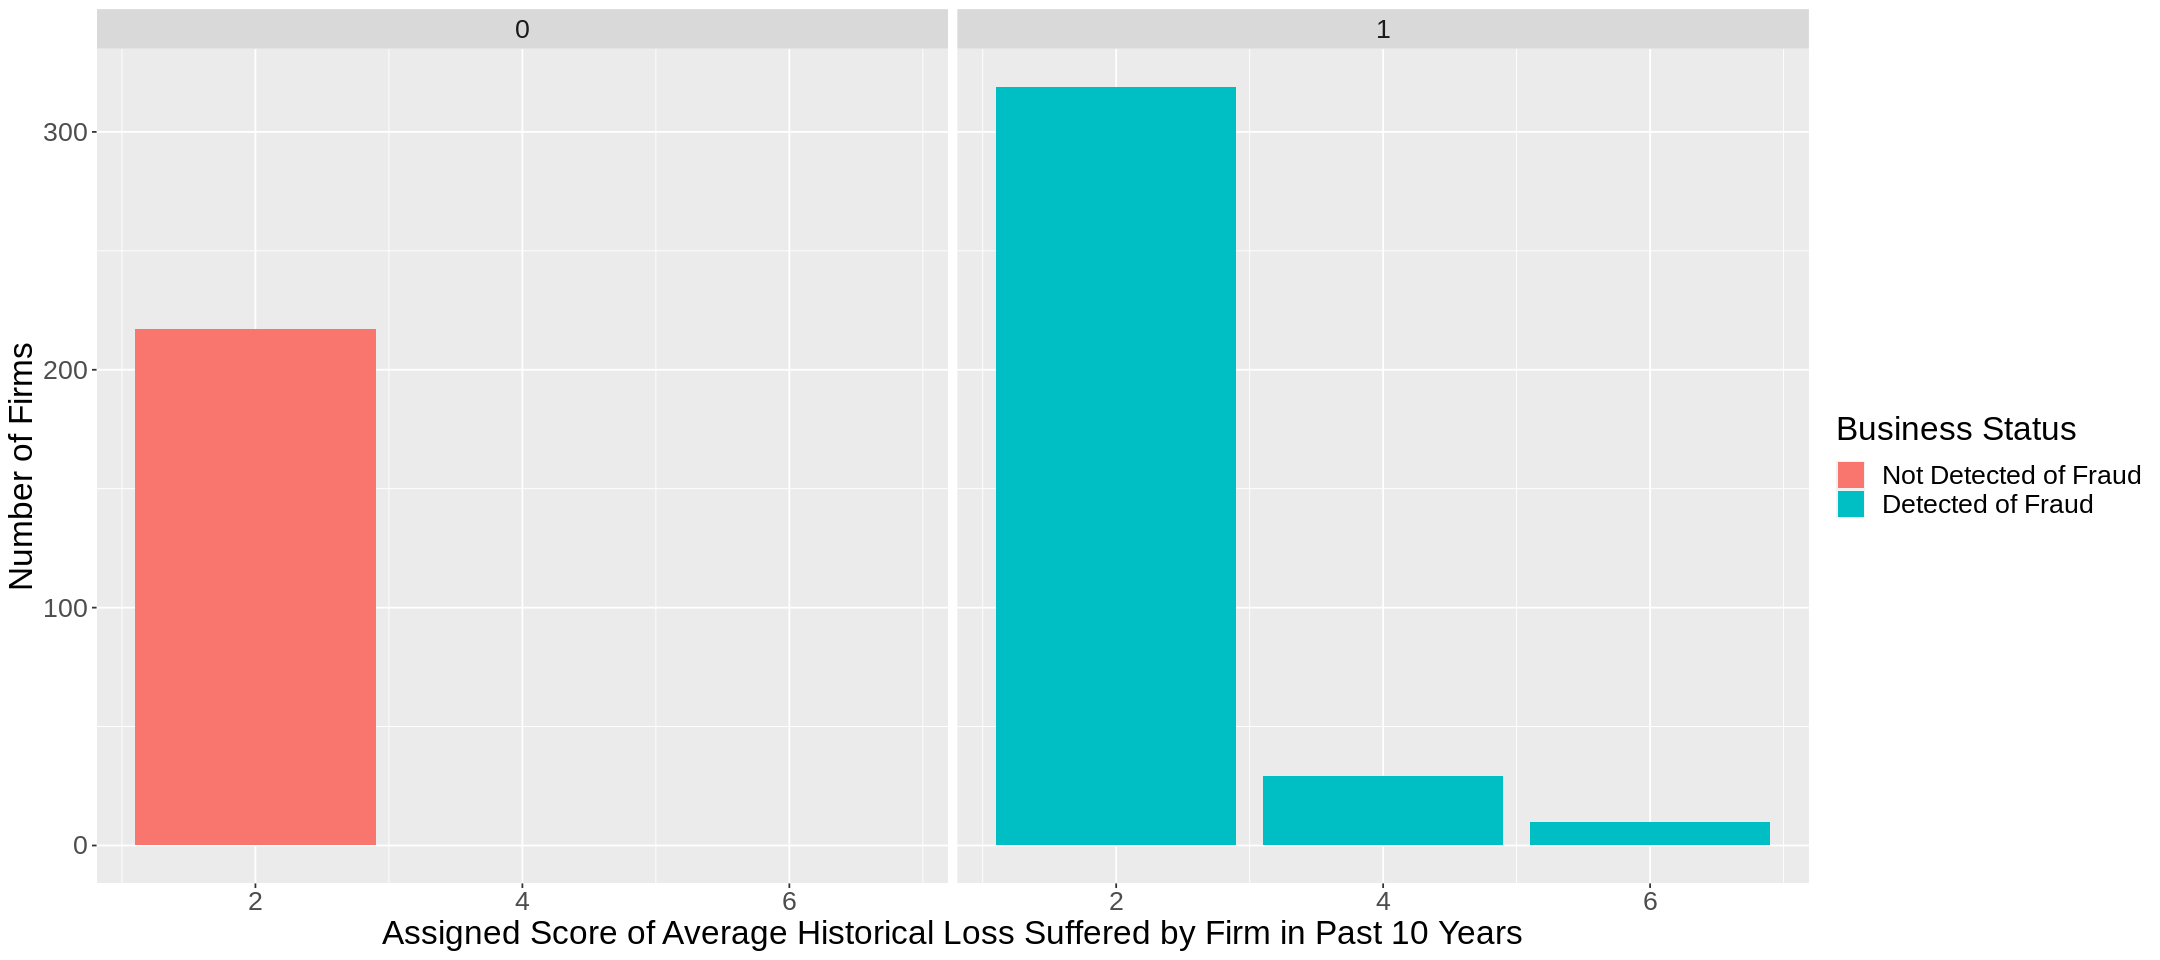

In [12]:
history

#### Figure 6: History Score
These historical risk scores of the businesses’ associated historical financial loss from the past 10 years were assigned by data collectors, with higher scores associated with higher risk. The businesses not detected of fraud all had historical loss scores of 2, while the businesses detected of fraud had scores of mostly  2, with a few having scores of 4 and 6.

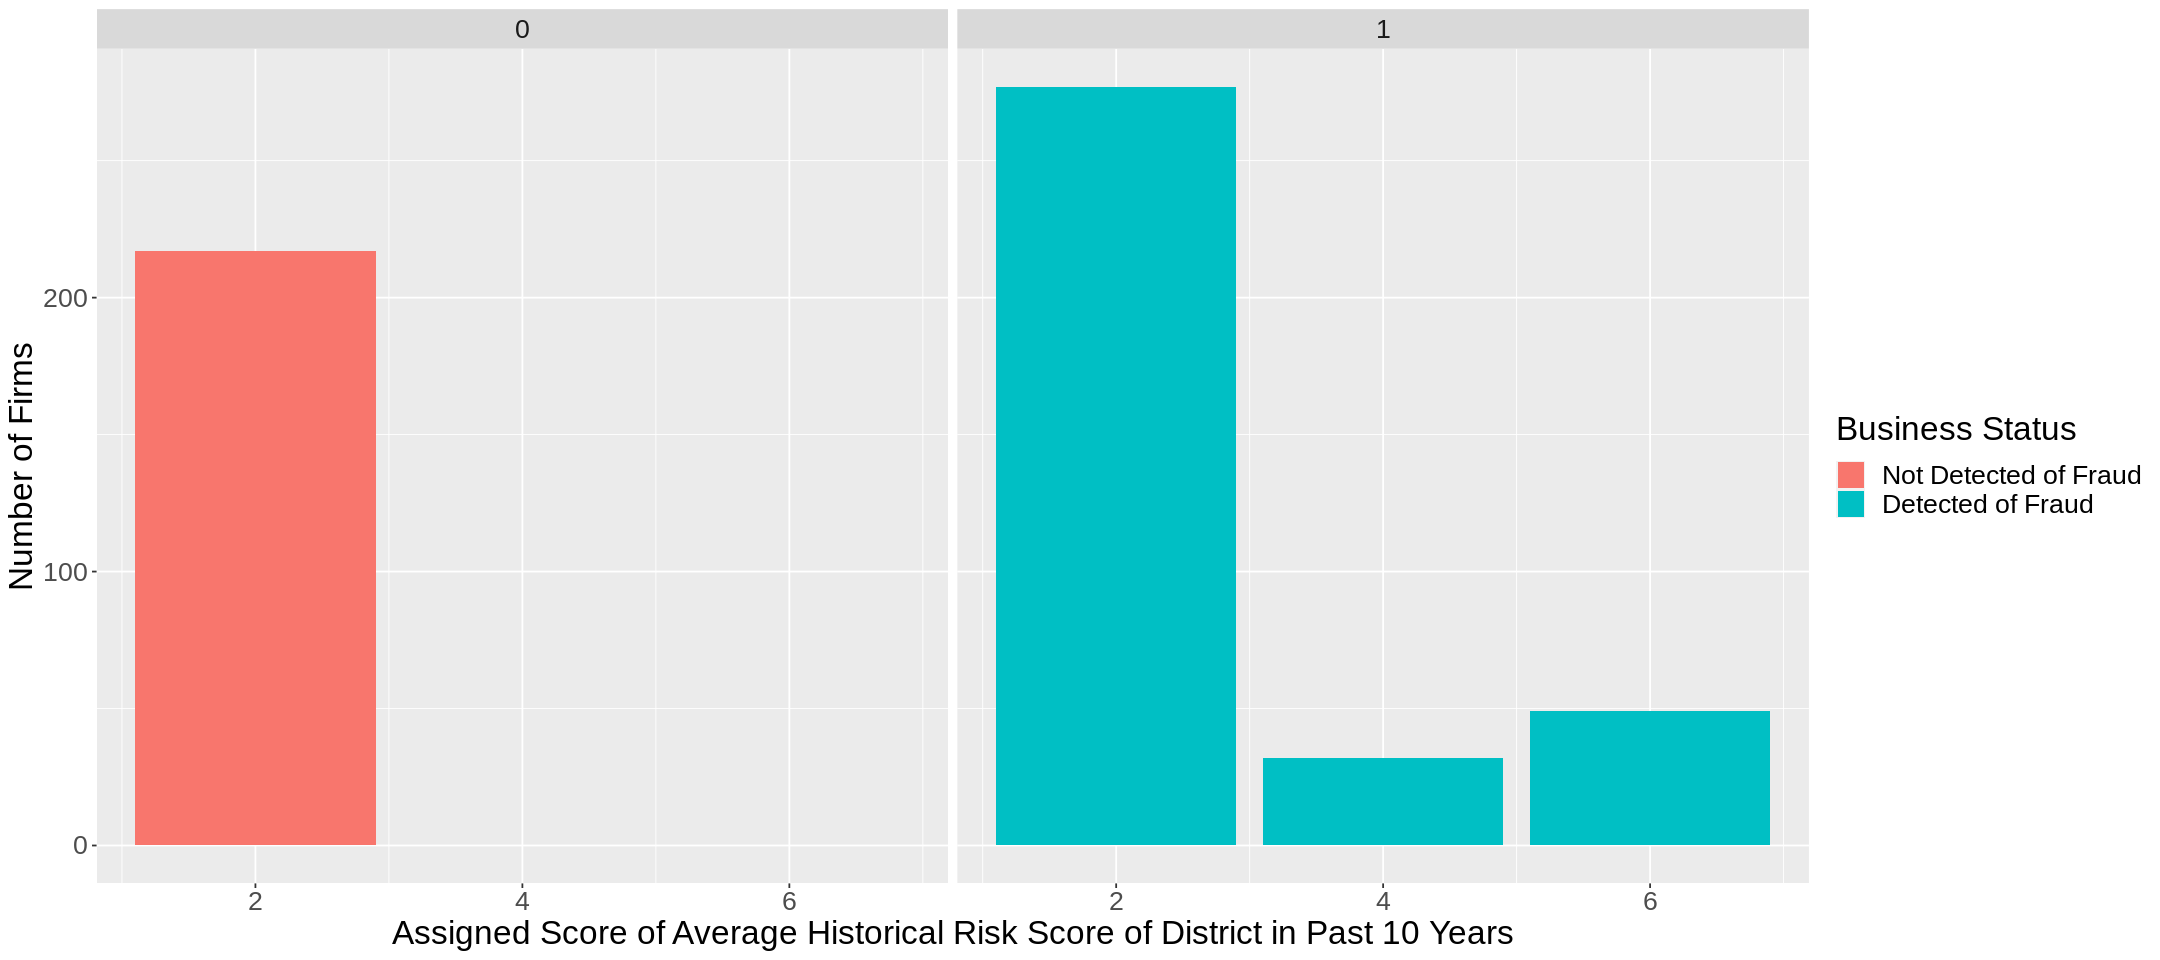

In [13]:
district

#### Figure 7: District Score
These historical risk scores of businesses’ associated districts (geographical location) were assigned by data collectors, with higher scores associated with higher risk. The businesses not detected of fraud all had historical risk scores of 2, while the businesses detected of fraud had scores of mostly  2, with some having scores of 4 and 6.

## Method

In our study, we will use the K-nearest neighbors classification model to best predict whether an Indian business firm is fraudulent based on 3 inherent risk factors and 4 control risk factors. We chose these variables:
- PARA_A and PARA_B: the difference between planned and unplanned expenditures of a company versus the actual expenditures auditors discover, respectively
- Money_Value: Amount of money involved in misstatements in the past audits
- Sector_score”, “Loss_score”, “District”, and “History_score”: the risk score based on a company’s sector, past year financial loss, the administrative district a company is located in, and historic financial loss in the past decade

We choose the 3 inherent risk factors variables because a large gap between a company's reported and actual financial status can indicate that a company is not disclosing practices and the 4 control risk factors indicate that a certain background of a company is associated with higher possibility of committing fraud.

We will conduct a cross-validation on the initial model to find the K that yields the highest accuracy. It will then be fitted to the training data, and we will test the model’s accuracy using the testing data.

Our final visualization will be a bar graph with two bars, each bar representing firms detected/not detected of fraud with a certain portion of them coloured in to indicate the portion of firms with their fraud status correctly predicted by our model. We will also visualize the data in a 2x2 confusion matrix, revealing the accuracy of our model on the test data.

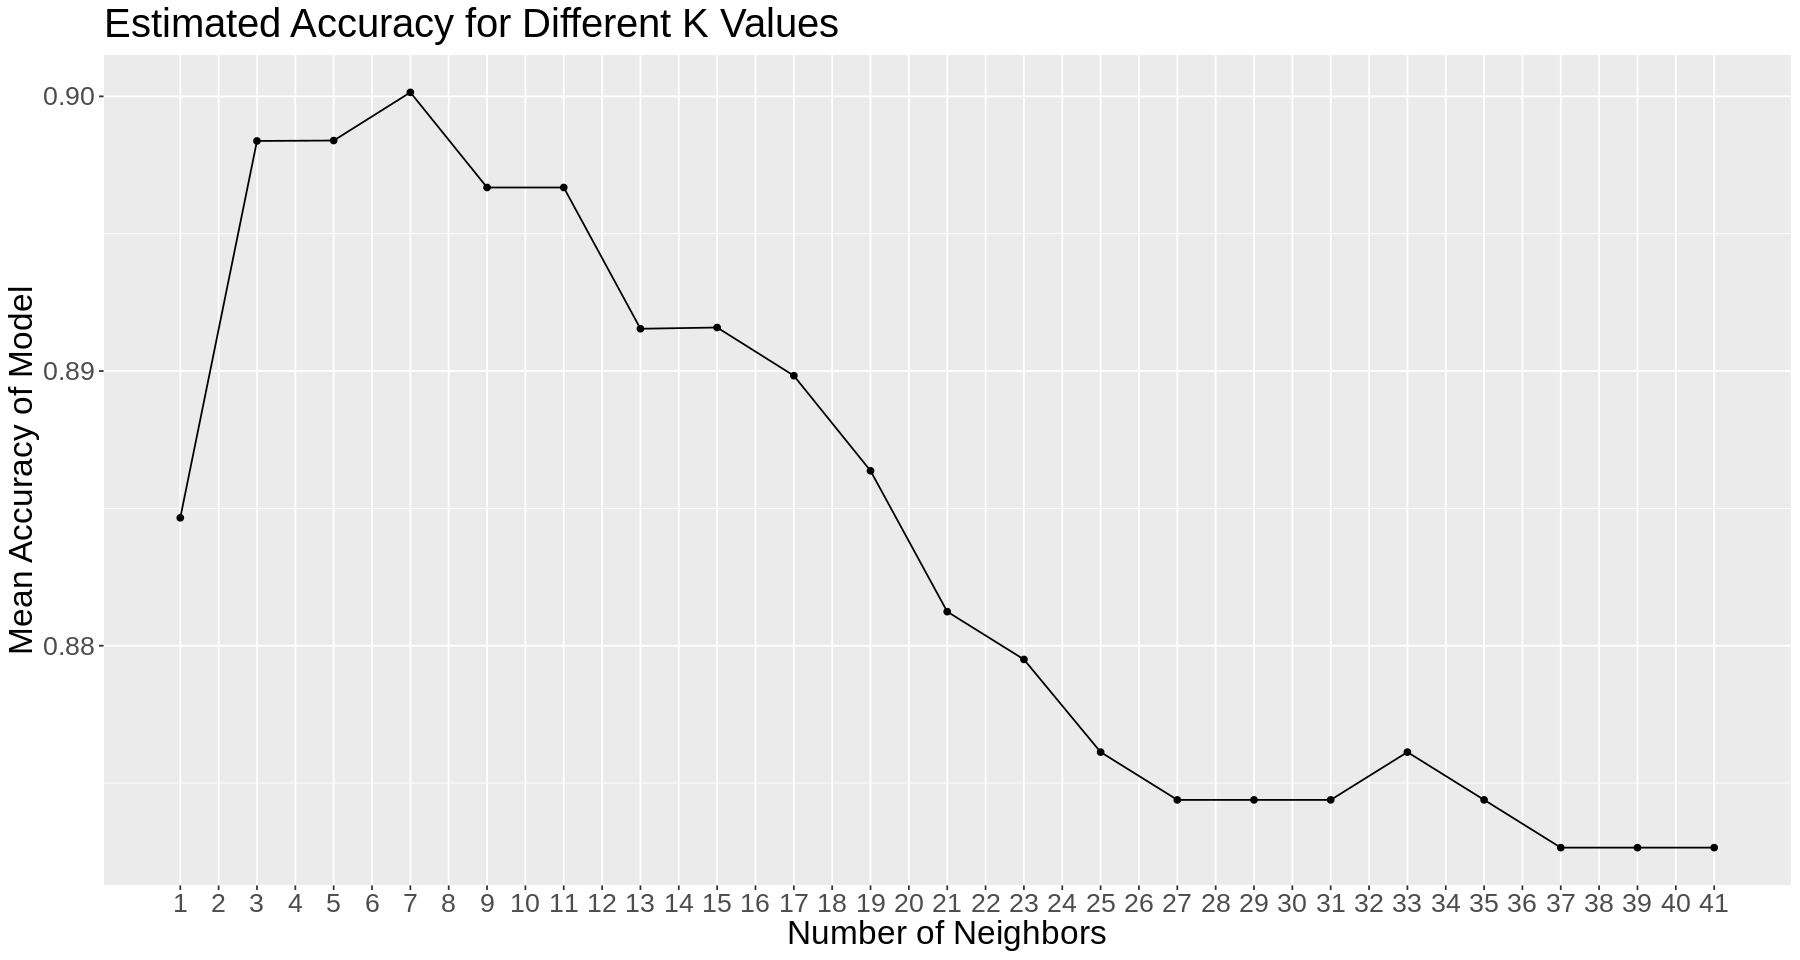

In [14]:
knn_recipe <- recipe(Risk ~ PARA_A + PARA_B + Money_Value, data = audit_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

k_lots <- tibble(neighbors = seq(from = 1, to = 41, by = 2))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = audit_vfold, grid = k_lots) |>
    collect_metrics()

options(repr.plot.width = 15, repr.plot.height = 8)
cross_val_plot <- knn_results |> filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean))+
        geom_point()+
        geom_line()+
        labs(x = "Number of Neighbors",
             y = "Mean Accuracy of Model",
             title = "Estimated Accuracy for Different K Values")+
        theme(text = element_text(size = 20)) +
        scale_x_continuous(limits = c(1, 41),
                       breaks = seq(from = 1, to = 41),
                       minor_breaks = seq(from = 1, to = 41, by = 2))

cross_val_plot

Figure 8: Cross Validation for k Nearest Neighbors. 
As expected, the accuracy of the model will increase with added neighbors (because overfitting is reduced), but eventually the accuracy will dip down as the model begins to undefit, so we choose the k where the estimated accuracy of the model peaks.

Since k = 7 gives the highest mean accuracy in the cross validation, we will choose k = 7 for our final model.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9072165
kap,binary,0.8098868


          Truth
Prediction   0   1
         0  71  17
         1   1 105

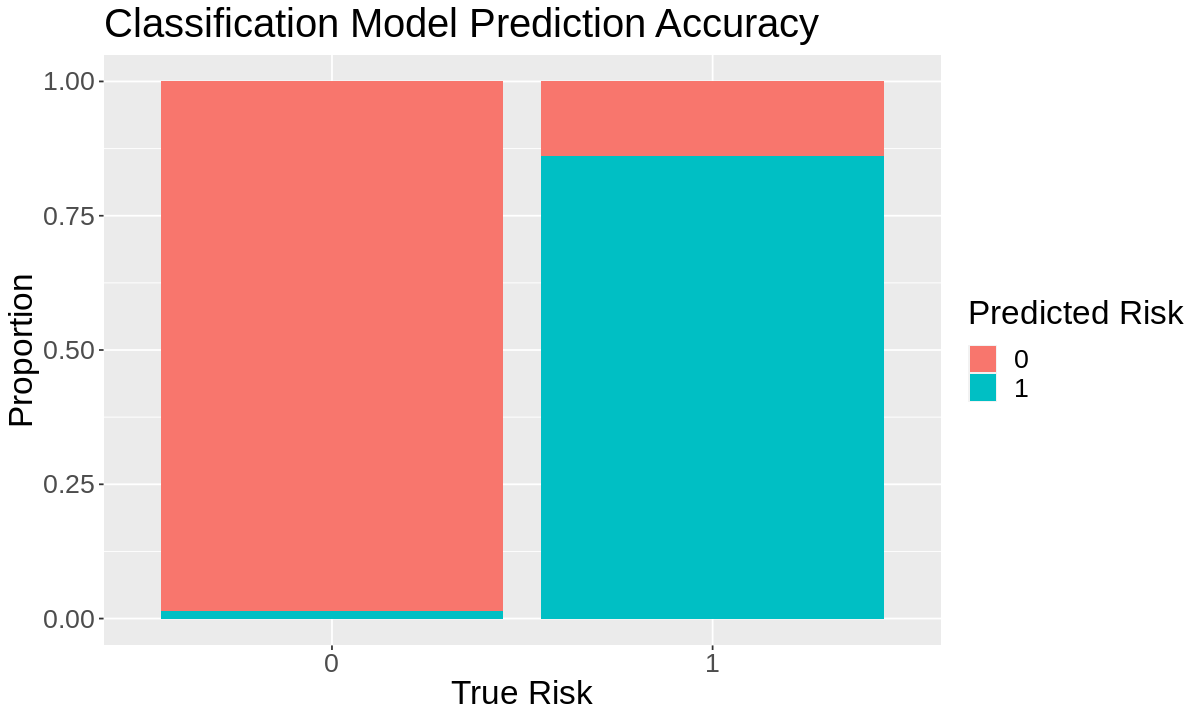

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(audit_train)

predictions <- predict(knn_fit, audit_test) |>
    bind_cols(audit_test)
metrics <- predictions |>
    metrics(truth = Risk, estimate = .pred_class)
conf_mat <- predictions |>
    conf_mat(truth = Risk, estimate = .pred_class)

options(repr.plot.width = 10, repr.plot.height = 6)
conf_mat_plot <- predictions |>
    ggplot(aes(x = Risk, fill = .pred_class))+
        geom_bar(position = "fill")+
        labs(x = "True Risk",
             fill = "Predicted Risk",
             y = "Proportion",
            title = "Classification Model Prediction Accuracy")+
        theme(text = element_text(size = 20))

metrics
conf_mat
conf_mat_plot

Figure 9: Visualization of the Model's Accuracy

From the graph we can see that the model is better at predicting firms that are not fraudulent, but both classes correct predictions greatly outweighing the incorrect ones.

## Expected Outcome and Significance

We expect to create a classifier that can accurately predict whether a firm in India is fraudulent based on the 7 inherent and control risk factors. We hope this model will help Indian auditors find out whether a firm is likely to be fraudulent based on their audit data faster.

Some questions that the results may lead to are: 

- How can this model apply to a larger geographical extent (in addition to India) and more types of companies? 
- How is each variable related to whether or not a firm is fraudulent?
- How would weighting the variables affect the prediction? 

### Citations

https://archive.ics.uci.edu/ml/datasets/Audit+Data

Nishtha Hooda, Seema Bawa & Prashant Singh Rana (2018) Fraudulent Firm
Classification: A Case Study of an External Audit, Applied Artificial Intelligence, 32:1, 48-64, DOI:
10.1080/08839514.2018.1451032
